# PISCES - Data curation and pre processing

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
import peptides as pep

pd.set_option('display.max_columns', 100)

## Download raw data

The Version of the PISCES dataset we used, is now archieved and can be downloaded as:   
#! wget https://dunbrack.fccc.edu/pisces/download/pisces_lists_2023_10_05.tar.gz


The exactly parameter chosen are described below:   
cullpdb_pc50.0_res0.0-3.0_noBrks_len40-10000_R0.3_Xray_d2023_10_05_chains24357

## Cleaning fasta files names

In [2]:
# Open the new file for writing
with open('data/cullpdb_pc50.0_res0.0-3.0_noBrks_len40-10000_R0.3_Xray_d2023_10_05_chains24357_processed.fasta', 'w') as f:
    # Parse the original FASTA file
    for record in SeqIO.parse('data/cullpdb_pc50.0_res0.0-3.0_noBrks_len40-10000_R0.3_Xray_d2023_10_05_chains24357.fasta', 'fasta'):
        # Create a new record with only the protein ID and the sequence, this will avoid the error like too long id in esm2 embedding extraction
        new_record = SeqIO.SeqRecord(seq=record.seq, id=record.id, description="")
        # Write the new record to the file
        SeqIO.write(new_record, f, 'fasta')


In [3]:
ids = []
for record in SeqIO.parse('data/cullpdb_pc50.0_res0.0-3.0_noBrks_len40-10000_R0.3_Xray_d2023_10_05_chains24357.fasta', 'fasta'):
    if record.id in ids:
        print(f'Duplicated ID: {record.id}')
    ids.append(record.id)

## Data Preprocessing - PDB files from PISCES list

In [3]:
meta_data = pd.read_table('data/pisces/cullpdb_pc50.0_res0.0-3.0_noBrks_len40-10000_R0.3_Xray_d2023_10_05_chains24357', sep='\s+')

# creates a column with the PDB ID, exclusive of the chain ID
ids = [x[:4] for x in meta_data['PDBchain']]
chain = [x[-1] for x in meta_data['PDBchain']]
meta_data.insert(0, 'PDB_ID', ids)
meta_data.insert(1, 'Chain', chain)
meta_data

,PDB_ID,Chain,PDBchain,len,method,resol,rfac,freerfac
0,5D8V,A,5D8VA,83,XRAY,0.48,0.072,0.078
1,3NIR,A,3NIRA,46,XRAY,0.48,0.127,NaN
2,5NW3,A,5NW3A,54,XRAY,0.59,0.135,0.146
3,1UCS,A,1UCSA,64,XRAY,0.62,0.139,0.155
4,3X2M,A,3X2MA,180,XRAY,0.64,0.122,0.129
...,...,...,...,...,...,...,...,...
24352,8HDD,B,8HDDB,482,XRAY,3.00,0.278,0.323
24353,5C6P,A,5C6PA,459,XRAY,3.00,0.280,0.290
24354,4LID,B,4LIDB,106,XRAY,3.00,0.286,0.251
24355,1ZP2,A,1ZP2A,235,XRAY,3.00,0.290,0.288


In [4]:
meta_data['Chain'].unique()

array(['A', 'B', 'L', 'S', 'X', 'C', 'D', 'P', 'F', 'M', 'O', 'I', 'E',
       'Y', 'U', 'G', 'H', 'T', 'J', 'K', 'N', 'Z', 'Q', '1', '2', '3',
       '0', 'R', 'W', 'V', '4', 'a', 'b', 'd', 'e', 'y', 't', 'q', 'p',
       '8', 'n', '5', '6', '7', '9'], dtype=object)

In [5]:
meta_data.query('Chain == "Z"')

,PDB_ID,Chain,PDBchain,len,method,resol,rfac,freerfac
2723,8ESE,Z,8ESEZ,184,XRAY,1.350,0.216,0.241
11656,5B66,Z,5B66Z,62,XRAY,1.850,0.164,0.201
15478,1H2V,Z,1H2VZ,156,XRAY,2.000,0.212,0.247
17231,4YBB,Z,4YBBCZ,62,XRAY,2.100,0.219,0.234
17663,5V07,Z,5V07Z,352,XRAY,2.150,0.179,0.220
18492,1VQO,Z,1VQOZ,83,XRAY,2.200,0.215,0.246
20724,2QOJ,Z,2QOJZ,254,XRAY,2.400,0.219,0.276
23089,6AGG,Z,6AGGZ,420,XRAY,2.706,0.215,0.298
23149,3OEE,Z,3OEEZ,138,XRAY,2.740,0.213,0.259


<Axes: ylabel='Frequency'>

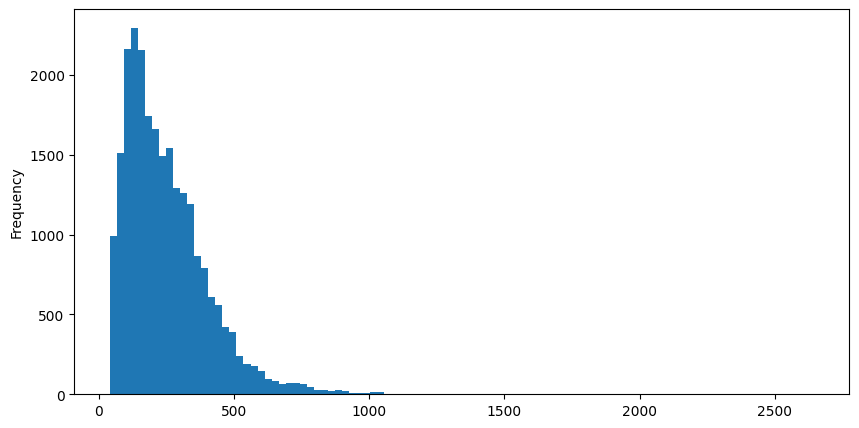

In [6]:
meta_data['len'].plot(kind='hist', bins=100, figsize=(10, 5))

<Axes: ylabel='Frequency'>

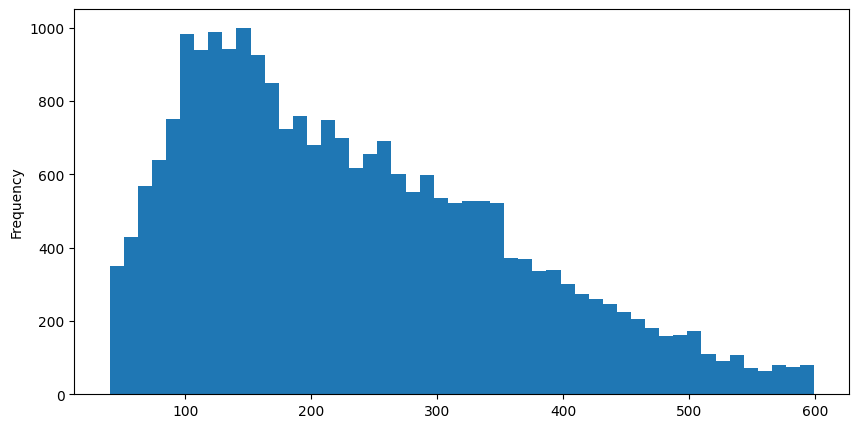

In [16]:
meta_data.query('len < 600')['len'].plot(kind='hist', bins=50, figsize=(10, 5))

In [18]:
meta_data.query('len < 500').shape

(22761, 8)

In [9]:
#meta_data['PDB_ID'].to_csv('data/pisces_pdb_ids.txt', index=False, header=False, sep=',')

In [10]:
## this script will download the pdb files

#!/bin/bash

# Check if the data directory exists, if not, create it
# mkdir -p data/pdb_files

# # Read each line of the txt file
# while read -r pdb_id; do
#     # Check if the pdb_id isn't empty
#     if [[ ! -z "$pdb_id" ]]; then
#         # Download the PDB file for the current ID
#         curl -f "https://files.rcsb.org/download/${pdb_id}.pdb.gz" -o "data/pdb_files/${pdb_id}.pdb.gz"
#     fi
# done < data/pisces_pdb_ids.txt

In [11]:
files = os.listdir('data/pdb_files')
files_to_check = [x.split('.pdb')[0] for x in files]

In [12]:
ids_to_drop = []
for file in meta_data['PDB_ID'].to_list():
    if file not in files_to_check:
        ids_to_drop.append(file)

len(ids_to_drop)

334

In [13]:
meta_data = meta_data[~meta_data['PDB_ID'].isin(ids_to_drop)].copy()
meta_data.rename(columns={'PDBchain': 'ID'}, inplace=True)
meta_data

,PDB_ID,Chain,ID,len,method,resol,rfac,freerfac
0,5D8V,A,5D8VA,83,XRAY,0.48,0.072,0.078
1,3NIR,A,3NIRA,46,XRAY,0.48,0.127,NaN
2,5NW3,A,5NW3A,54,XRAY,0.59,0.135,0.146
3,1UCS,A,1UCSA,64,XRAY,0.62,0.139,0.155
4,3X2M,A,3X2MA,180,XRAY,0.64,0.122,0.129
...,...,...,...,...,...,...,...,...
24352,8HDD,B,8HDDB,482,XRAY,3.00,0.278,0.323
24353,5C6P,A,5C6PA,459,XRAY,3.00,0.280,0.290
24354,4LID,B,4LIDB,106,XRAY,3.00,0.286,0.251
24355,1ZP2,A,1ZP2A,235,XRAY,3.00,0.290,0.288


In [14]:
records = SeqIO.parse('data/cullpdb_pc50.0_res0.0-3.0_noBrks_len40-10000_R0.3_Xray_d2023_10_05_chains24357_processed.fasta', 'fasta')
sequences = {}
for rec in records:
    sequences[rec.id] = str(rec.seq)

# adding sequences to meta_data
seqDF = pd.DataFrame.from_dict(sequences, orient='index', columns=['sequence'])

meta_data = meta_data.merge(seqDF, how='left', left_on='ID', right_index=True)
meta_data

,PDB_ID,Chain,ID,len,method,resol,rfac,freerfac,sequence
0,5D8V,A,5D8VA,83,XRAY,0.48,0.072,0.078,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...
1,3NIR,A,3NIRA,46,XRAY,0.48,0.127,NaN,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN
2,5NW3,A,5NW3A,54,XRAY,0.59,0.135,0.146,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...
3,1UCS,A,1UCSA,64,XRAY,0.62,0.139,0.155,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...
4,3X2M,A,3X2MA,180,XRAY,0.64,0.122,0.129,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...
...,...,...,...,...,...,...,...,...,...
24352,8HDD,B,8HDDB,482,XRAY,3.00,0.278,0.323,MGKSTLTFLIAGCLALPGFARAADAADPALVKRGEYLATAGDCMAC...
24353,5C6P,A,5C6PA,459,XRAY,3.00,0.280,0.290,LDRFSFSVFLKEIRLLTALALPMLLAQVAQVGIGFVDTVMAGGAGK...
24354,4LID,B,4LIDB,106,XRAY,3.00,0.286,0.251,MVSPQTRKEEELLEKQNSVFYLLTLGRKPYGSYLHIKIELDEDEKL...
24355,1ZP2,A,1ZP2A,235,XRAY,3.00,0.290,0.288,YWASSQLTQLFLSTDLESLEPTCLSKDTIYQWKVVQTFGDRLRLRQ...


In [15]:
cols =['ID', 'PDB_ID', 'Chain', 'sequence', 'len', 'method', 'resol', 'rfac', 'freerfac',]
meta_data = meta_data[cols].copy()
meta_data

,ID,PDB_ID,Chain,sequence,len,method,resol,rfac,freerfac
0,5D8VA,5D8V,A,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,83,XRAY,0.48,0.072,0.078
1,3NIRA,3NIR,A,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN,46,XRAY,0.48,0.127,NaN
2,5NW3A,5NW3,A,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,54,XRAY,0.59,0.135,0.146
3,1UCSA,1UCS,A,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,64,XRAY,0.62,0.139,0.155
4,3X2MA,3X2M,A,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...,180,XRAY,0.64,0.122,0.129
...,...,...,...,...,...,...,...,...,...
24352,8HDDB,8HDD,B,MGKSTLTFLIAGCLALPGFARAADAADPALVKRGEYLATAGDCMAC...,482,XRAY,3.00,0.278,0.323
24353,5C6PA,5C6P,A,LDRFSFSVFLKEIRLLTALALPMLLAQVAQVGIGFVDTVMAGGAGK...,459,XRAY,3.00,0.280,0.290
24354,4LIDB,4LID,B,MVSPQTRKEEELLEKQNSVFYLLTLGRKPYGSYLHIKIELDEDEKL...,106,XRAY,3.00,0.286,0.251
24355,1ZP2A,1ZP2,A,YWASSQLTQLFLSTDLESLEPTCLSKDTIYQWKVVQTFGDRLRLRQ...,235,XRAY,3.00,0.290,0.288


In [16]:
#meta_data.to_csv('data/pisces_meta_data.csv', index=False)

## Get UniProt protein ID

In [ ]:
# import os
# from Bio.PDB import PDBList, MMCIFParser, PDBParser

# def get_uniprot_id(pdb_id):
#     pdbl = PDBList()
#     parser = MMCIFParser()  # You can also use PDBParser() for PDB files

#     # Download PDB structure file in MMCIF format
#     file_path = pdbl.retrieve_pdb_file(pdb_id, file_format='mmCif', pdir='.')

#     # Parse the structure
#     structure = parser.get_structure(pdb_id, file_path)

#     # Iterate over all entities and check for UniProt annotation
#     for model in structure:
#         for chain in model:
#             for residue in chain.get_unpacked_list():
#                 if 'db_accession' in residue.xtra:
#                     uniprot_id = residue.xtra['db_accession']
#                     return uniprot_id

#     return "UniProt ID not found"

# # Example Usage
# pdb_id = '3NIR'  # Replace with your PDB ID
# uniprot_id = get_uniprot_id(pdb_id)
# print(uniprot_id)

In [ ]:
# url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id}"
# response = requests.get(url)
    
# if response.status_code == 200:
#     data = response.json()
#         # Extracting UniProt ID from the response
#         # The exact path may vary depending on the structure of the response
#     #for entity in data:#.get("rcsb_entry_container_identifiers"):#.get("entry_id", []):
#     for entity in data.get("rcsb_entry_info"):#.get("entry_id", []):
#         uniprot_id = entity#.get("uniprot_ids")

#         print(entity)
#         #print(uniprot_id)

In [ ]:
# import requests
# import json

# def get_uniprot_id(pdb_id):
#     url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id}"
#     response = requests.get(url)
    
#     if response.status_code == 200:
#         data = response.json()
#         # Extracting UniProt ID from the response
#         # The exact path may vary depending on the structure of the response
#         for entity in data.get("rcsb_entry_container_identifiers", {}).get("polymer_entity_ids", []):
#             uniprot_id = entity.get("uniprot_ids")
#             if uniprot_id:
#                 return uniprot_id
#         return "UniProt ID not found"
#     else:
#         return "Error: Unable to fetch data from RCSB PDB"

# # Example Usage
# pdb_id = '1A4U'  # Replace with your PDB ID
# uniprot_id = get_uniprot_id(pdb_id)
# print(uniprot_id)

## Compute Secondary structure

    H: Alpha helix - A right-handed coil or spiral conformation in protein structure.  
    B: Isolated beta-bridge - A single pair of beta strands connected by hydrogen bonds.  
    E: Extended strand (beta strand) - Part of a beta sheet, a common protein secondary structure.  
    G: 3-10 helix - A helix with a tighter turn than an alpha helix, with three residues per turn.  
    I: Pi helix - A rarer, more extended helix than the alpha helix.  
    T: Hydrogen bonded turn - A tight bend in the protein chain, stabilized by hydrogen bonding.  
    S: Bend - A region where the protein chain bends sharply.  
    -: None - No regular secondary structure (often loop or random coil regions).  

In [54]:
meta_data = pd.read_csv('data/pisces_meta_data.csv')
meta_data

,ID,PDB_ID,Chain,sequence,len,method,resol,rfac,freerfac
0,5D8VA,5D8V,A,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,83,XRAY,0.48,0.072,0.078
1,3NIRA,3NIR,A,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN,46,XRAY,0.48,0.127,NaN
2,5NW3A,5NW3,A,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,54,XRAY,0.59,0.135,0.146
3,1UCSA,1UCS,A,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,64,XRAY,0.62,0.139,0.155
4,3X2MA,3X2M,A,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...,180,XRAY,0.64,0.122,0.129
...,...,...,...,...,...,...,...,...,...
24018,8HDDB,8HDD,B,MGKSTLTFLIAGCLALPGFARAADAADPALVKRGEYLATAGDCMAC...,482,XRAY,3.00,0.278,0.323
24019,5C6PA,5C6P,A,LDRFSFSVFLKEIRLLTALALPMLLAQVAQVGIGFVDTVMAGGAGK...,459,XRAY,3.00,0.280,0.290
24020,4LIDB,4LID,B,MVSPQTRKEEELLEKQNSVFYLLTLGRKPYGSYLHIKIELDEDEKL...,106,XRAY,3.00,0.286,0.251
24021,1ZP2A,1ZP2,A,YWASSQLTQLFLSTDLESLEPTCLSKDTIYQWKVVQTFGDRLRLRQ...,235,XRAY,3.00,0.290,0.288


In [7]:
from Bio.PDB import PDBParser, DSSP

# Load the PDB file
pdb_file = '/stor/work/Wilke/luiz/LEAP/data/1A0A.pdb'
structure_id = '1A0A' 
chain = 'A'

parser = PDBParser()
structure = parser.get_structure(structure_id, pdb_file)

# Run DSSP - assuming DSSP is installed and in the path
model = structure[0]  #take the first model, most common
dssp = DSSP(model, pdb_file)


# Assuming dssp is already correctly set up as before
sec_structures = {'H': 0, 'B': 0, 'E': 0, 'G': 0, 'I': 0, 'T': 0, 'S': 0, '-': 0}
count = 0
for key in dssp.keys():
    chain_id = key[0]
    # this condiction will check if the chain is the one we want
    if chain_id == chain:
        ss_dict = dssp[key][2] # Get the secondary structure type 
        if ss_dict in sec_structures:
            sec_structures[ss_dict] += 1
            count += 1
    else:
        continue

# Calculate frequencies
total = sum(sec_structures.values())
if total > 0:
    frequencies = {ss: count / total for ss, count in sec_structures.items()}
else:
    frequencies = {ss: 0 for ss, count in sec_structures.items()}

#print(sec_structures)
print(frequencies)
print(count)

{'H': 0.5396825396825397, 'B': 0.0, 'E': 0.0, 'G': 0.07936507936507936, 'I': 0.0, 'T': 0.12698412698412698, 'S': 0.07936507936507936, '-': 0.1746031746031746}
63


In [70]:
from Bio.PDB import PDBParser, DSSP
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Ignore PDBConstructionWarning
warnings.simplefilter('ignore', PDBConstructionWarning)

def get_secondary_structure(pdb_file, chain):
    """Returns the secondary structure of a given chain in a PDB file.

    Parameters
    ----------
    pdb_file : str
        Path to the PDB file.
    chain : str
        Chain identifier.

    Returns
    -------
    dict
        A dictionary containing the secondary structure frequencies.
    """

    try:
        # Load the PDB file
        structure_id = os.path.basename(pdb_file).split('.')[0]
        parser = PDBParser()
        structure = parser.get_structure(structure_id, pdb_file)

        # Run DSSP - assuming DSSP is installed and in the path
        model = structure[0]  #take the first model, most common
        dssp = DSSP(model, pdb_file, dssp='mkdssp')

        # Assuming dssp is already correctly set up as before
        sec_structures = {'H': 0, 'B': 0, 'E': 0, 'G': 0, 'I': 0, 'T': 0, 'S': 0, '-': 0}
        for key in dssp.keys():
            chain_id = key[0]
            # this condiction will check if the chain is the one we want
            if chain_id == chain:
                ss_dict = dssp[key][2] # Get the secondary structure type 
                if ss_dict in sec_structures:
                    sec_structures[ss_dict] += 1
            else:
                continue

        # Calculate frequencies
        total = sum(sec_structures.values()) # total of residues
        if total > 0:
            frequencies = {ss: count / total for ss, count in sec_structures.items()}
        else:
            frequencies = {ss: 0 for ss, count in sec_structures.items()}

        return frequencies

    
    except Exception as e:
        print(f"Error processing {pdb_file}: {e}")
        # Return a dictionary with NaNs or zeros
        return {'H': np.nan, 'B': np.nan, 'E': np.nan, 'G': np.nan, 'I': np.nan, 'T': np.nan, 'S': np.nan, '-': np.nan}


# Test the function
pdb_file = '/stor/work/Wilke/luiz/LEAP/data/pdb_files/1A0A.pdb'
chain = 'A'
get_secondary_structure(pdb_file, chain)

{'H': 0.5396825396825397,
 'B': 0.0,
 'E': 0.0,
 'G': 0.07936507936507936,
 'I': 0.0,
 'T': 0.12698412698412698,
 'S': 0.07936507936507936,
 '-': 0.1746031746031746}

In [ ]:
meta_data[['ss_H', 'ss_B', 'ss_E', 'ss_G', 'ss_I', 'ss_T', 'ss_S', 'ss_Coil']] = meta_data.apply(
    lambda row: pd.Series(get_secondary_structure(f"data/pdb_files/{row['PDB_ID']}.pdb", row['Chain'])),
    axis=1
)
meta_data

In [103]:
meta_data = pd.read_csv('data/meta_data/pisces_meta_data_SS.csv')
meta_data

,ID,PDB_ID,Chain,sequence,len,method,resol,rfac,freerfac,ss_H,ss_B,ss_E,ss_G,ss_I,ss_T,ss_S,ss_Coil
0,5D8VA,5D8V,A,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,83,XRAY,0.48,0.072,0.078,0.120482,0.072289,0.156627,0.108434,0.000000,0.228916,0.060241,0.253012
1,3NIRA,3NIR,A,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN,46,XRAY,0.48,0.127,NaN,0.413043,0.000000,0.086957,0.000000,0.000000,0.108696,0.152174,0.239130
2,5NW3A,5NW3,A,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,54,XRAY,0.59,0.135,0.146,0.000000,0.074074,0.185185,0.166667,0.000000,0.259259,0.037037,0.277778
3,1UCSA,1UCS,A,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,64,XRAY,0.62,0.139,0.155,0.062500,0.125000,0.125000,0.140625,0.000000,0.125000,0.109375,0.312500
4,3X2MA,3X2M,A,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...,180,XRAY,0.64,0.122,0.129,0.050000,0.011111,0.250000,0.055556,0.000000,0.155556,0.144444,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24016,8HDDB,8HDD,B,MGKSTLTFLIAGCLALPGFARAADAADPALVKRGEYLATAGDCMAC...,482,XRAY,3.00,0.278,0.323,0.247934,0.000000,0.000000,0.049587,0.041322,0.123967,0.231405,0.305785
24017,5C6PA,5C6P,A,LDRFSFSVFLKEIRLLTALALPMLLAQVAQVGIGFVDTVMAGGAGK...,459,XRAY,3.00,0.280,0.290,0.368192,0.000000,0.000000,0.034858,0.000000,0.291939,0.150327,0.154684
24018,4LIDB,4LID,B,MVSPQTRKEEELLEKQNSVFYLLTLGRKPYGSYLHIKIELDEDEKL...,106,XRAY,3.00,0.286,0.251,0.418605,0.000000,0.360465,0.000000,0.000000,0.093023,0.058140,0.069767
24019,1ZP2A,1ZP2,A,YWASSQLTQLFLSTDLESLEPTCLSKDTIYQWKVVQTFGDRLRLRQ...,235,XRAY,3.00,0.290,0.288,0.603524,0.000000,0.000000,0.039648,0.000000,0.110132,0.070485,0.176211


In [80]:
#meta_data[~meta_data['H'].isna()].to_csv('data/pisces_meta_data_SS.csv', index=False)

In [8]:
def randomly_delete_zeros(df, column, retain_percentage=0.10):
    # Ensure column exists in DataFrame
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    # Identify zero entries
    zero_indices = df[df[column] == 0].index

    # Calculate the number of zeros to delete
    n_delete = len(zero_indices) - int(len(zero_indices) * retain_percentage)

    # Check if there's anything to delete
    if n_delete <= 0:
        return df

    # Randomly select indices to delete
    indices_to_delete = np.random.choice(zero_indices, n_delete, replace=False)

    # Delete these indices from the DataFrame and return
    return df.drop(indices_to_delete)

# Usage Example:
#randomly_delete_zeros(meta_data, 'ss_H', retain_percentage=0.10)

In [104]:
targets = ['ss_H', 'ss_B', 'ss_E', 'ss_G', 'ss_I', 'ss_T', 'ss_S', 'ss_Coil']

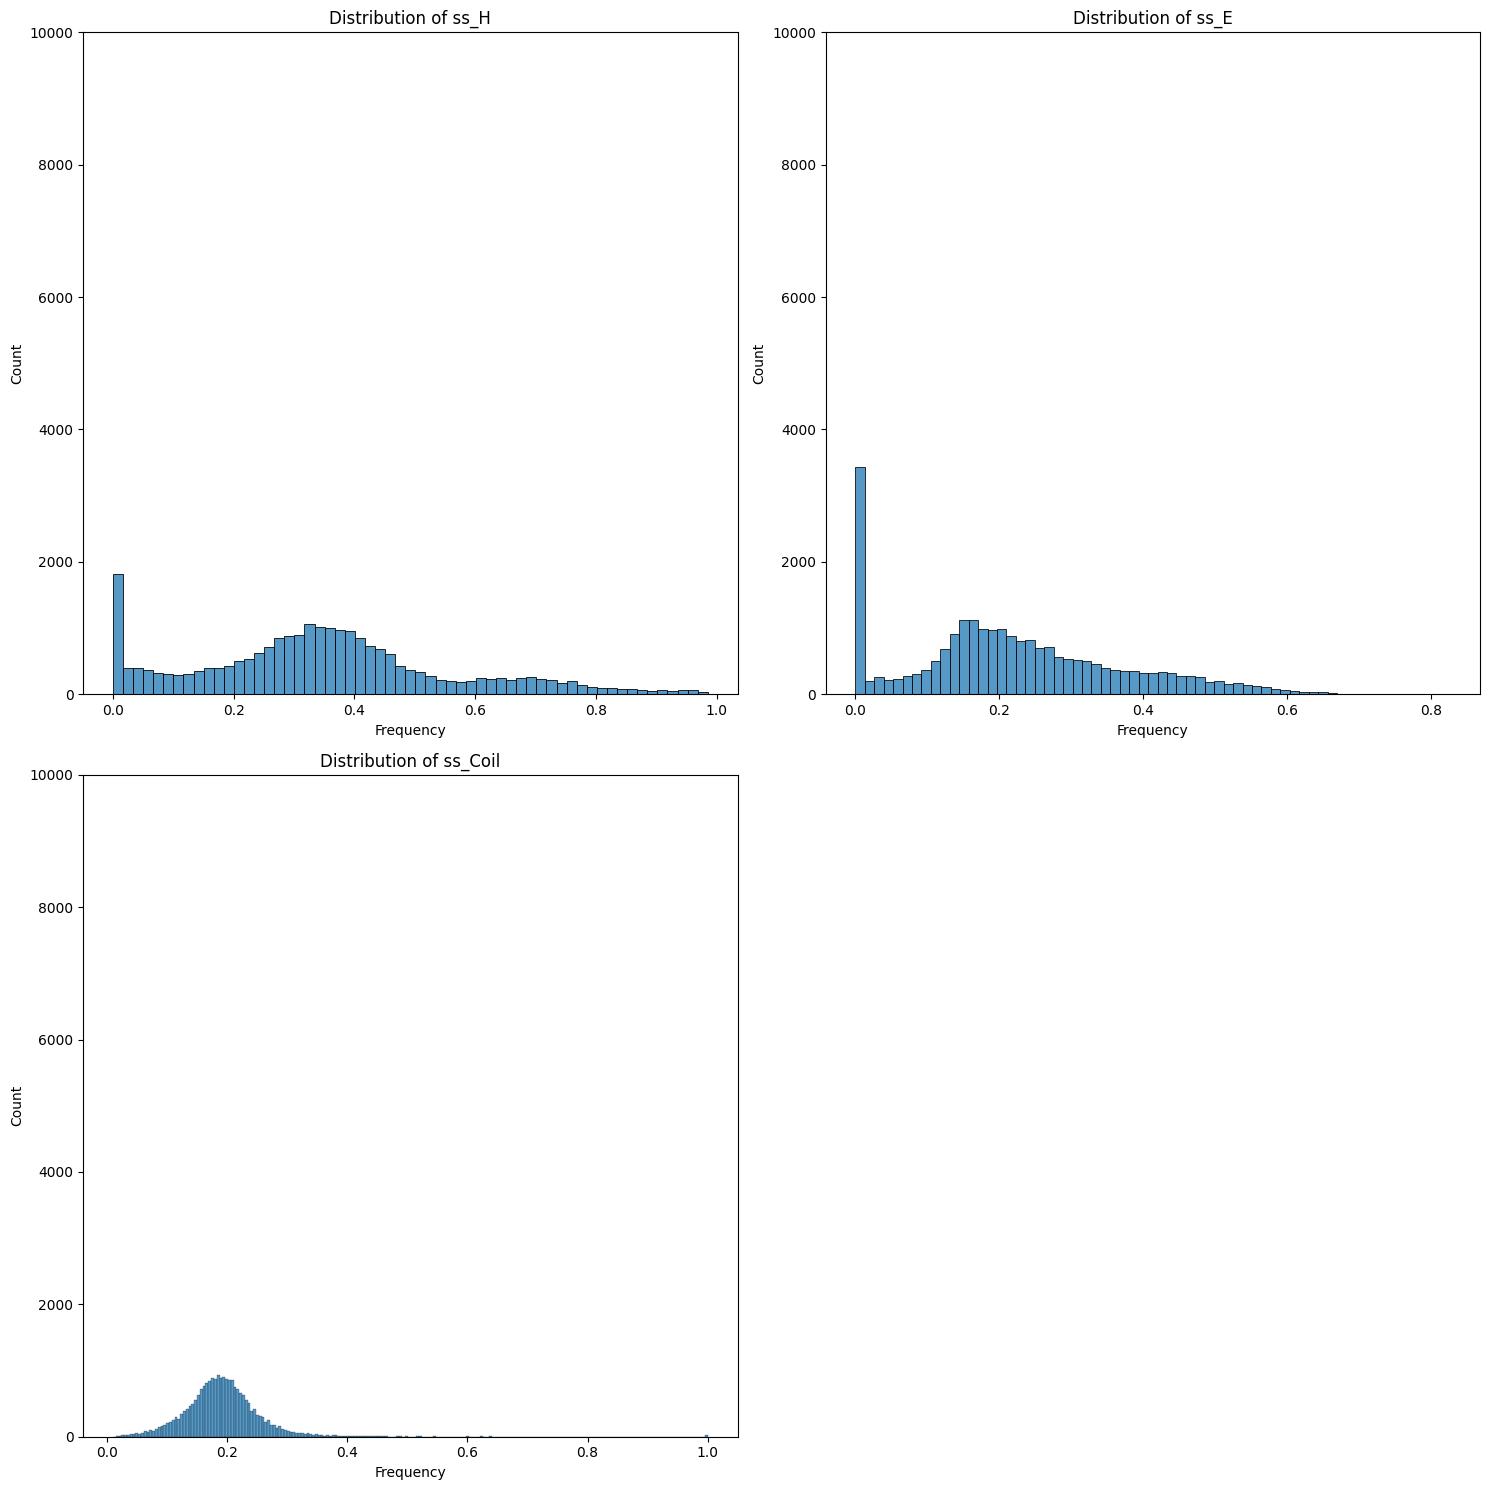

In [105]:
import math

# Determine the grid size for subplots
grid_size = math.ceil(math.sqrt(len(targets)))

# Create a figure and a grid of subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))

# Flatten the axes array
axs = axs.flatten()

for i, target in enumerate(targets):
    sns.histplot(meta_data[target], kde=False, ax=axs[i])
    axs[i].set_title(f'Distribution of {target}')
    axs[i].set_xlabel('Frequency')
    axs[i].set_ylabel('Count')
    axs[i].set_ylim(0, 10000)

# Remove unused subplots
for i in range(len(targets), len(axs)):
    fig.delaxes(axs[i])


plt.tight_layout()
plt.show()

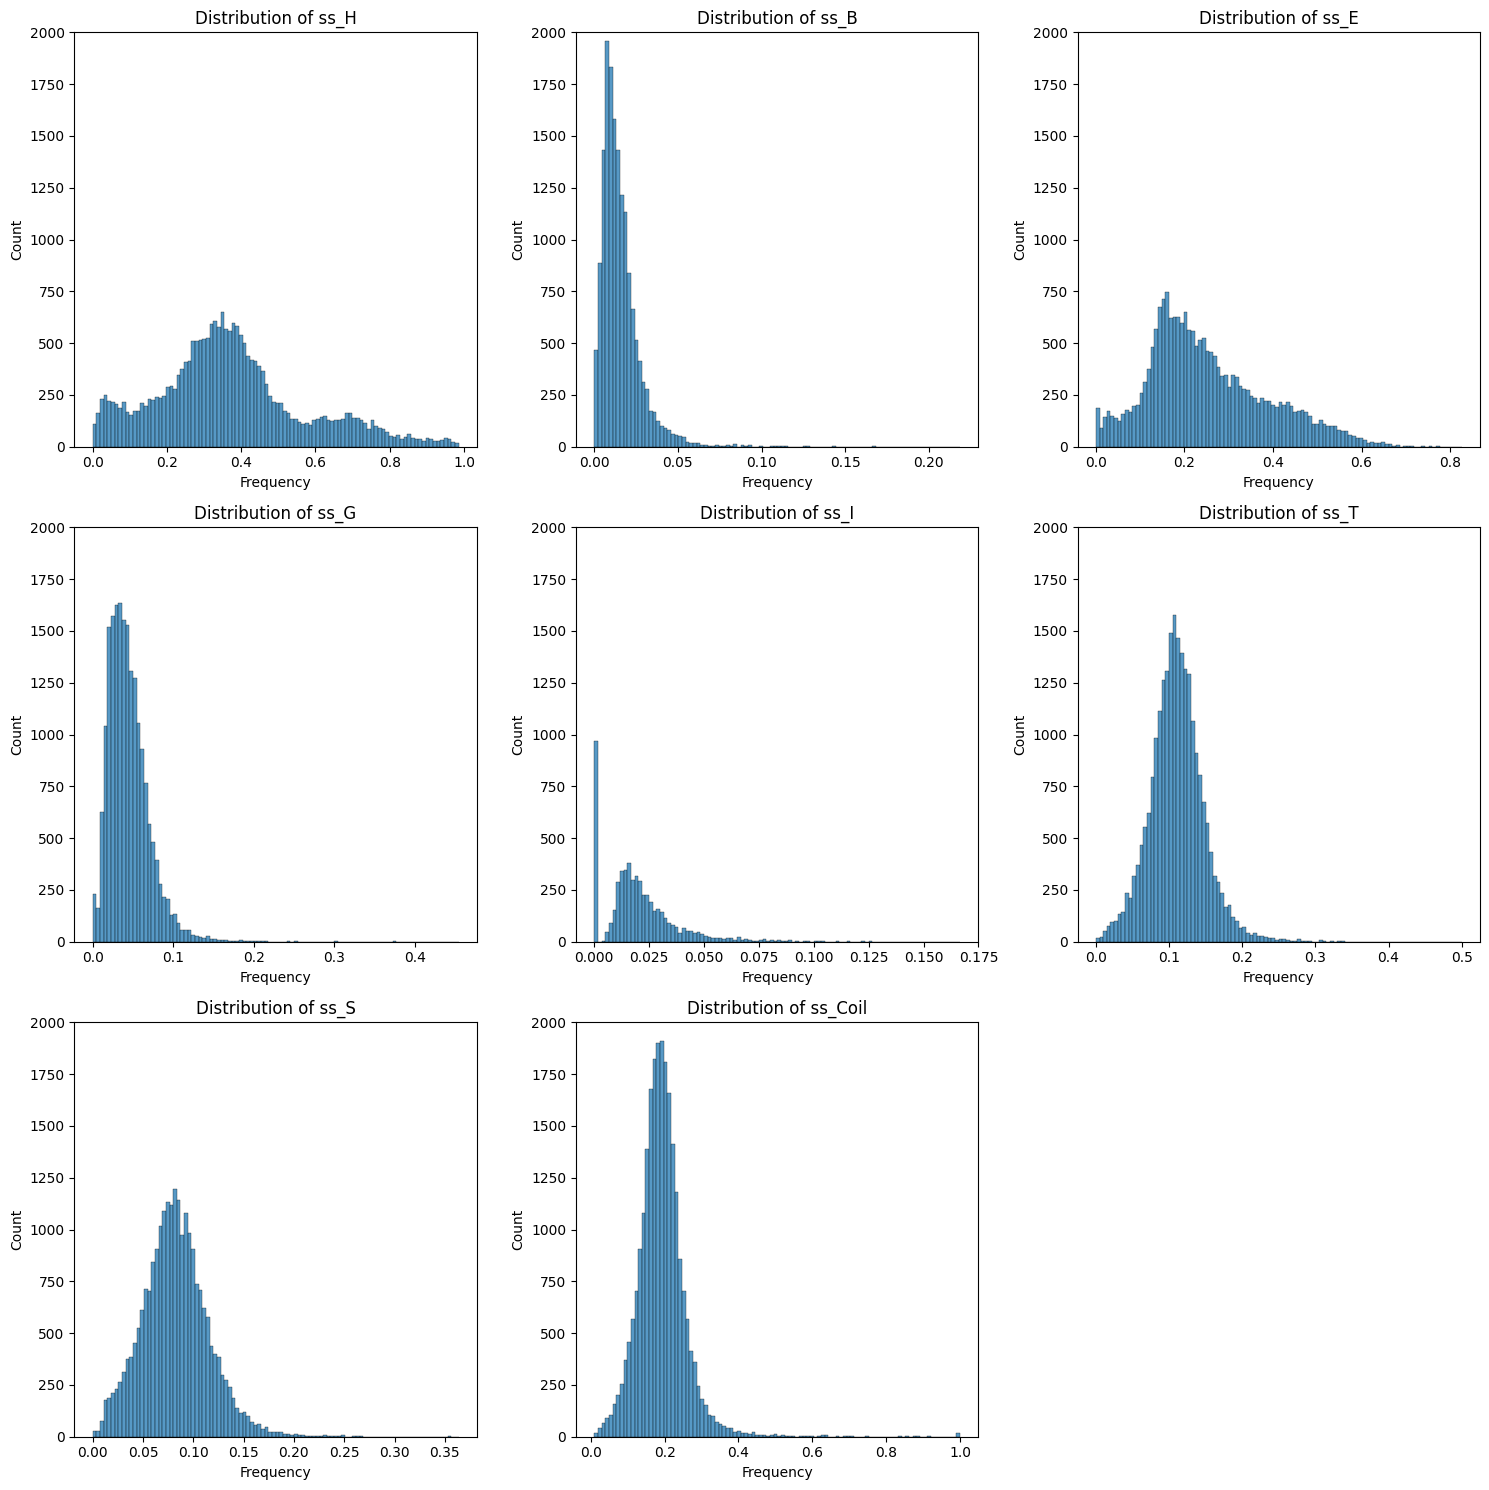

In [87]:
import math

# Determine the grid size for subplots
grid_size = math.ceil(math.sqrt(len(targets)))

# Create a figure and a grid of subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))

# Flatten the axes array
axs = axs.flatten()

for i, target in enumerate(targets):
    if target in ['ss_H', 'ss_B', 'ss_E', 'ss_G', 'ss_I', 'ss_T', 'ss_S', 'ss_Coil']:
        #sns.histplot(randomly_delete_zeros(meta_data, target, retain_percentage=0.10).query(f'{str(target)} != 0')[target], kde=False, ax=axs[i], bins=100)
        sns.histplot(randomly_delete_zeros(meta_data, target, retain_percentage=0.05)[target], kde=False, ax=axs[i], bins=100)
        axs[i].set_title(f'Distribution of {target}')
        axs[i].set_title(f'Distribution of {target}')
        axs[i].set_xlabel('Frequency')
        axs[i].set_ylabel('Count')
        axs[i].set_ylim(0, 2000)
    else:
        #sns.histplot(meta_data.query(f'{str(target)} != 0')[target], kde=False, ax=axs[i])
        sns.histplot(meta_data[target], kde=False, ax=axs[i])
        axs[i].set_title(f'Distribution of {target}')
        axs[i].set_title(f'Distribution of {target}')
        axs[i].set_xlabel('Frequency')
        axs[i].set_ylabel('Count')
        axs[i].set_ylim(0, 2000)

# Remove unused subplots
for i in range(len(targets), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

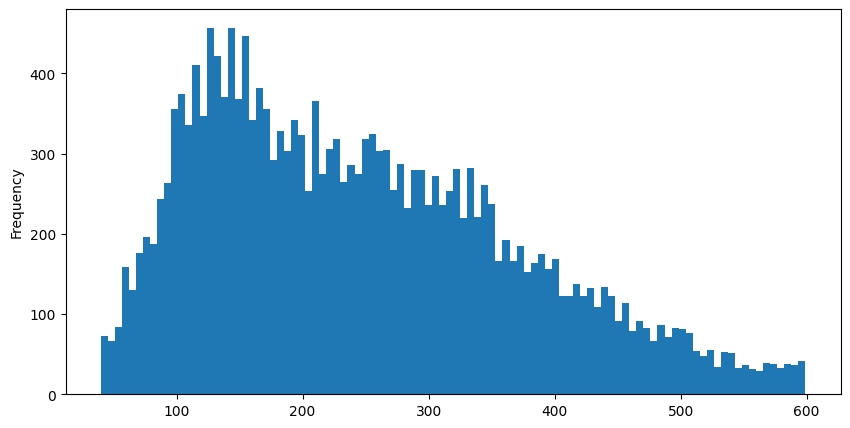

In [20]:
df = pd.read_csv('data/meta_data/pisces_meta_data_SS.csv')
df = df.query('len <600')
df = randomly_delete_zeros(df, 'ss_E', retain_percentage=0.05)
df['len'].plot(kind='hist', bins=100, figsize=(10, 5))
df[['ID', 'sequence', 'ss_E']].to_csv('fineTune/data/pisces_meta_data_SS_ssE.csv', index=False)

## Protein Physical-Chimical Properties

In [108]:
meta_data = pd.read_csv('data/meta_data/pisces_meta_data.csv')
meta_data

,ID,PDB_ID,Chain,sequence,len,method,resol,rfac,freerfac
0,5D8VA,5D8V,A,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,83,XRAY,0.48,0.072,0.078
1,3NIRA,3NIR,A,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN,46,XRAY,0.48,0.127,NaN
2,5NW3A,5NW3,A,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,54,XRAY,0.59,0.135,0.146
3,1UCSA,1UCS,A,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,64,XRAY,0.62,0.139,0.155
4,3X2MA,3X2M,A,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...,180,XRAY,0.64,0.122,0.129
...,...,...,...,...,...,...,...,...,...
24018,8HDDB,8HDD,B,MGKSTLTFLIAGCLALPGFARAADAADPALVKRGEYLATAGDCMAC...,482,XRAY,3.00,0.278,0.323
24019,5C6PA,5C6P,A,LDRFSFSVFLKEIRLLTALALPMLLAQVAQVGIGFVDTVMAGGAGK...,459,XRAY,3.00,0.280,0.290
24020,4LIDB,4LID,B,MVSPQTRKEEELLEKQNSVFYLLTLGRKPYGSYLHIKIELDEDEKL...,106,XRAY,3.00,0.286,0.251
24021,1ZP2A,1ZP2,A,YWASSQLTQLFLSTDLESLEPTCLSKDTIYQWKVVQTFGDRLRLRQ...,235,XRAY,3.00,0.290,0.288


In [ ]:
# compute some PCP features
meta_data['Instability_index'] = [round(pep.Peptide(s).instability_index(), 2) for s in meta_data.sequence]    
meta_data['Hydrophobicity'] = [round(pep.Peptide(s).hydrophobicity(scale="KyteDoolittle"), 2) for s in meta_data.sequence]  
meta_data['Charge'] = [round(pep.Peptide(s).charge(pH=7, pKscale= 'Lehninger'), 2) for s in meta_data.sequence]  # default values
meta_data['Isoelectric_point'] = [round(pep.Peptide(s).isoelectric_point(pKscale= 'Lehninger'), 2) for s in meta_data.sequence]  # default values
meta_data['mW_kDa'] = [round(pep.Peptide(s).molecular_weight() / 1000, 2) for s in meta_data.sequence] 
meta_data['Isoelectric_point'] = [round(pep.Peptide(s).isoelectric_point(pKscale= 'Lehninger'), 2) for s in meta_data.sequence]


## compute AA frequencies
meta_data[['A_freq', 'C_freq', 'D_freq', 'E_freq', 'F_freq', 'G_freq', 'H_freq', 'I_freq', 'K_freq', 'L_freq', 'M_freq', 'N_freq', 'P_freq', 'Q_freq','R_freq', 'S_freq', 'T_freq', 'V_freq', 'W_freq', 'Y_freq']] = meta_data.apply(
    lambda row: pd.Series({k:v for k,v in pep.Peptide(row['sequence']).frequencies().items() if v != 0 and k not in ['B', 'O', 'U', 'X']}),
    axis=1
)


# this will fill the NaN values with 0, because the frequency of the amino acid is 0
col_fill = ['A_freq', 'C_freq', 'D_freq', 'E_freq', 'F_freq', 'G_freq', 'H_freq', 'I_freq', 'K_freq', 'L_freq', 'M_freq', 'N_freq', 'P_freq', 'Q_freq','R_freq', 'S_freq', 'T_freq', 'V_freq', 'W_freq', 'Y_freq']
meta_data[col_fill] = meta_data[col_fill].fillna(0)
meta_data

,ID,PDB_ID,Chain,sequence,len,method,resol,rfac,freerfac,Instability_index,Hydrophobicity,Charge,Isoelectric_point,mW_kDa,A_freq,C_freq,D_freq,E_freq,F_freq,G_freq,H_freq,I_freq,K_freq,L_freq,M_freq,N_freq,P_freq,Q_freq,R_freq,S_freq,T_freq,V_freq,W_freq,Y_freq
0,5D8VA,5D8V,A,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,83,XRAY,0.48,0.072,0.078,20.67,-0.36,-1.15,5.52,8.79,0.180723,0.048193,0.048193,0.048193,0.024096,0.084337,0.012048,0.024096,0.060241,0.060241,0.012048,0.072289,0.072289,0.060241,0.024096,0.024096,0.048193,0.048193,0.036145,0.012048
1,3NIRA,3NIR,A,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN,46,XRAY,0.48,0.127,NaN,31.89,0.35,-0.37,5.87,4.74,0.108696,0.130435,0.021739,0.021739,0.021739,0.086957,0.000000,0.086957,0.000000,0.043478,0.000000,0.065217,0.108696,0.000000,0.043478,0.043478,0.130435,0.043478,0.000000,0.043478
2,5NW3A,5NW3,A,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,54,XRAY,0.59,0.135,0.146,33.91,-0.52,-8.24,3.70,6.03,0.055556,0.074074,0.129630,0.111111,0.037037,0.092593,0.000000,0.074074,0.092593,0.037037,0.018519,0.018519,0.092593,0.000000,0.000000,0.037037,0.018519,0.037037,0.037037,0.037037
3,1UCSA,1UCS,A,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,64,XRAY,0.62,0.139,0.155,17.25,0.35,0.00,7.13,6.91,0.093750,0.000000,0.015625,0.062500,0.000000,0.046875,0.000000,0.078125,0.062500,0.093750,0.093750,0.078125,0.093750,0.031250,0.015625,0.015625,0.078125,0.125000,0.000000,0.015625
4,3X2MA,3X2M,A,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...,180,XRAY,0.64,0.122,0.129,39.45,-0.24,-5.25,4.81,18.17,0.105556,0.055556,0.033333,0.022222,0.061111,0.166667,0.022222,0.016667,0.022222,0.038889,0.011111,0.050000,0.066667,0.061111,0.005556,0.088889,0.100000,0.033333,0.016667,0.022222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24018,8HDDB,8HDD,B,MGKSTLTFLIAGCLALPGFARAADAADPALVKRGEYLATAGDCMAC...,482,XRAY,3.00,0.278,0.323,39.02,-0.19,8.85,8.95,51.74,0.116183,0.014523,0.047718,0.029046,0.024896,0.103734,0.029046,0.037344,0.047718,0.085062,0.026971,0.037344,0.076763,0.041494,0.045643,0.056017,0.051867,0.070539,0.020747,0.037344
24019,5C6PA,5C6P,A,LDRFSFSVFLKEIRLLTALALPMLLAQVAQVGIGFVDTVMAGGAGK...,459,XRAY,3.00,0.280,0.290,24.34,0.79,10.12,9.54,49.68,0.135076,0.008715,0.021786,0.023965,0.078431,0.095861,0.008715,0.067538,0.032680,0.122004,0.041394,0.013072,0.037037,0.023965,0.034858,0.071895,0.041394,0.076253,0.023965,0.041394
24020,4LIDB,4LID,B,MVSPQTRKEEELLEKQNSVFYLLTLGRKPYGSYLHIKIELDEDEKL...,106,XRAY,3.00,0.286,0.251,51.23,-0.65,-4.35,5.74,12.67,0.047170,0.000000,0.056604,0.132075,0.028302,0.018868,0.066038,0.075472,0.103774,0.141509,0.009434,0.028302,0.018868,0.056604,0.037736,0.047170,0.028302,0.047170,0.000000,0.056604
24021,1ZP2A,1ZP2,A,YWASSQLTQLFLSTDLESLEPTCLSKDTIYQWKVVQTFGDRLRLRQ...,235,XRAY,3.00,0.290,0.288,42.93,0.08,-6.45,5.91,27.07,0.076596,0.038298,0.046809,0.072340,0.038298,0.012766,0.051064,0.089362,0.051064,0.136170,0.008511,0.034043,0.021277,0.042553,0.038298,0.085106,0.046809,0.055319,0.017021,0.038298


In [78]:
#meta_data.to_csv('data/meta_data/pisces_meta_data_PCP.csv', index=False)

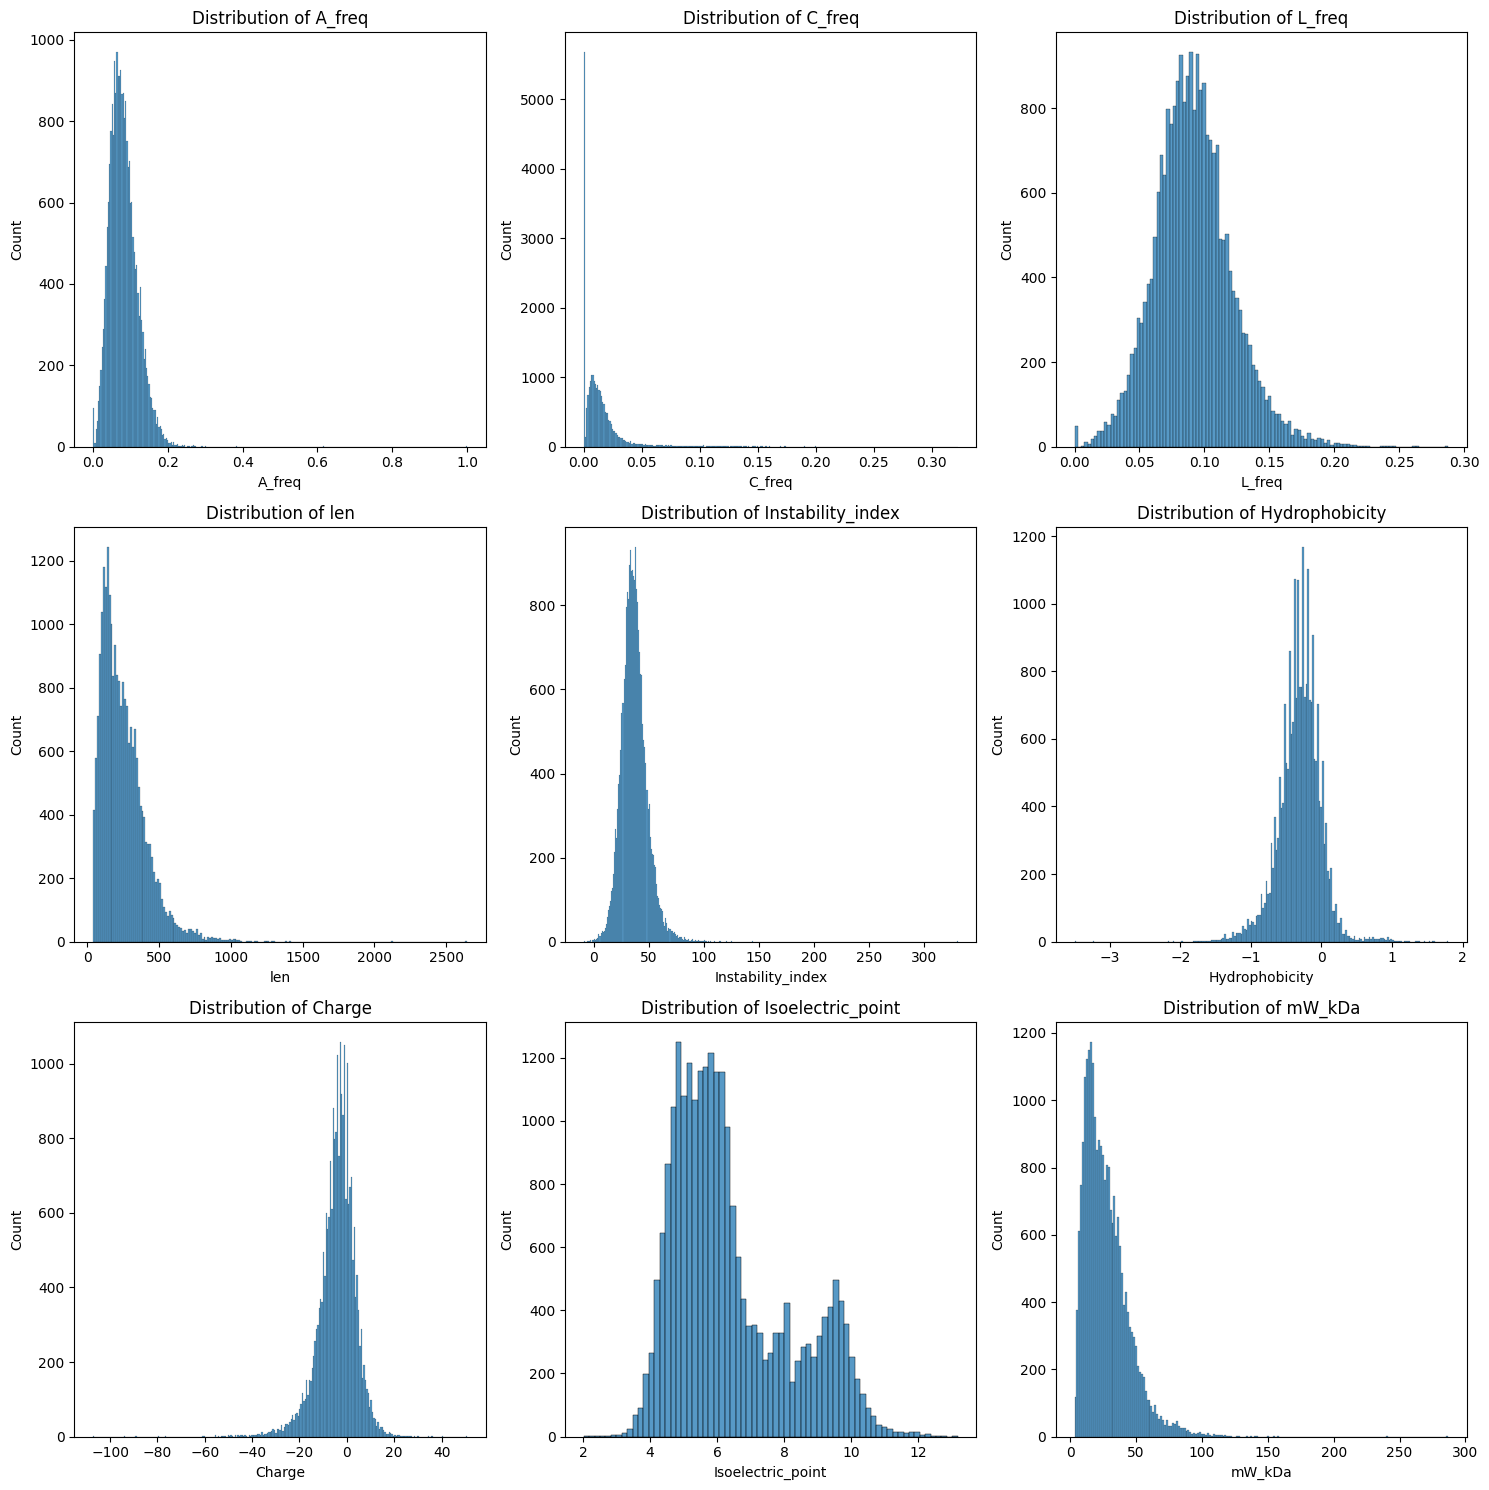

In [114]:
meta_data = pd.read_csv('data/meta_data/pisces_meta_data_PCP.csv')

# targets = ['A_freq', 'C_freq', 'D_freq','V_freq', 'W_freq', 'Y_freq',
#        'E_freq', 'F_freq', 'G_freq', 'H_freq', 'I_freq', 'K_freq', 'L_freq',
#        'M_freq', 'N_freq', 'P_freq', 'Q_freq', 'R_freq', 'S_freq', 'T_freq',
#        ]

targets = ['A_freq', 'C_freq', 'L_freq','len','Instability_index', 'Hydrophobicity', 'Charge',
       'Isoelectric_point', 'mW_kDa',
       ]


# Determine the grid size for subplots
grid_size = math.ceil(math.sqrt(len(targets)))

# Create a figure and a grid of subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))

# Flatten the axes array
axs = axs.flatten()

for i, target in enumerate(targets):
    sns.histplot(meta_data[target], kde=False, ax=axs[i])
    axs[i].set_title(f'Distribution of {target}')

# Remove unused subplots
for i in range(len(targets), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

In [ ]:
import math
import numpy as np
from scipy import stats

for target in ['Instability_index', 'Hydrophobicity', 'Charge', 'Isoelectric_point', 'mW_kDa', 'len']:

    sns.histplot(np.log2(meta_data[target]+1), kde=False, bins=100)
    plt.title(f'Distribution of {target}')
    plt.tight_layout()
    plt.show()

## Creating PISCES metadata

### Physicochemical properties (PCP)

In [2]:
import pandas as pd

pcp = pd.read_csv('data/PISCES/metadata_pisces_PCP.csv')
pcp

,ID,PDB_ID,Chain,sequence,len,method,resol,rfac,freerfac,Instability_index,...,M_freq,N_freq,P_freq,Q_freq,R_freq,S_freq,T_freq,V_freq,W_freq,Y_freq
0,5D8VA,5D8V,A,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,83,XRAY,0.48,0.072,0.078,20.67,...,0.012048,0.072289,0.072289,0.060241,0.024096,0.024096,0.048193,0.048193,0.036145,0.012048
1,3NIRA,3NIR,A,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN,46,XRAY,0.48,0.127,NaN,31.89,...,0.000000,0.065217,0.108696,0.000000,0.043478,0.043478,0.130435,0.043478,0.000000,0.043478
2,5NW3A,5NW3,A,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,54,XRAY,0.59,0.135,0.146,33.91,...,0.018519,0.018519,0.092593,0.000000,0.000000,0.037037,0.018519,0.037037,0.037037,0.037037
3,1UCSA,1UCS,A,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,64,XRAY,0.62,0.139,0.155,17.25,...,0.093750,0.078125,0.093750,0.031250,0.015625,0.015625,0.078125,0.125000,0.000000,0.015625
4,3X2MA,3X2M,A,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...,180,XRAY,0.64,0.122,0.129,39.45,...,0.011111,0.050000,0.066667,0.061111,0.005556,0.088889,0.100000,0.033333,0.016667,0.022222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24018,8HDDB,8HDD,B,MGKSTLTFLIAGCLALPGFARAADAADPALVKRGEYLATAGDCMAC...,482,XRAY,3.00,0.278,0.323,39.02,...,0.026971,0.037344,0.076763,0.041494,0.045643,0.056017,0.051867,0.070539,0.020747,0.037344
24019,5C6PA,5C6P,A,LDRFSFSVFLKEIRLLTALALPMLLAQVAQVGIGFVDTVMAGGAGK...,459,XRAY,3.00,0.280,0.290,24.34,...,0.041394,0.013072,0.037037,0.023965,0.034858,0.071895,0.041394,0.076253,0.023965,0.041394
24020,4LIDB,4LID,B,MVSPQTRKEEELLEKQNSVFYLLTLGRKPYGSYLHIKIELDEDEKL...,106,XRAY,3.00,0.286,0.251,51.23,...,0.009434,0.028302,0.018868,0.056604,0.037736,0.047170,0.028302,0.047170,0.000000,0.056604
24021,1ZP2A,1ZP2,A,YWASSQLTQLFLSTDLESLEPTCLSKDTIYQWKVVQTFGDRLRLRQ...,235,XRAY,3.00,0.290,0.288,42.93,...,0.008511,0.034043,0.021277,0.042553,0.038298,0.085106,0.046809,0.055319,0.017021,0.038298


In [3]:
pcp.columns

Index(['ID', 'PDB_ID', 'Chain', 'sequence', 'len', 'method', 'resol', 'rfac',
       'freerfac', 'Instability_index', 'Hydrophobicity', 'Charge',
       'Isoelectric_point', 'mW_kDa', 'A_freq', 'C_freq', 'D_freq', 'E_freq',
       'F_freq', 'G_freq', 'H_freq', 'I_freq', 'K_freq', 'L_freq', 'M_freq',
       'N_freq', 'P_freq', 'Q_freq', 'R_freq', 'S_freq', 'T_freq', 'V_freq',
       'W_freq', 'Y_freq'],
      dtype='object')

In [ ]:
# length
cols = ['ID', 'sequence', 'len']
length = pcp[cols].copy()
length.rename(columns={'len': 'target'}, inplace = True)
length.to_csv('data/PISCES/metadata_pisces_PCP_length.csv')

In [ ]:
# Hydrophobicity
cols = ['ID', 'sequence', 'len']
Hydrophobicity = pcp[cols].copy()
Hydrophobicity.rename(columns={'len': 'target'}, inplace = True)
Hydrophobicity.to_csv('data/PISCES/metadata_pisces_PCP_Hydrophobicity.csv')

In [ ]:
# Charge
cols = ['ID', 'sequence', 'Charge']
Charge = pcp[cols].copy()
Charge.rename(columns={'Charge': 'target'}, inplace = True)
Charge.to_csv('data/PISCES/metadata_pisces_PCP_Charge.csv')

In [ ]:
# Isoelectric_point
cols = ['ID', 'sequence', 'Isoelectric_point']
Isoelectric_point = pcp[cols].copy()
Isoelectric_point.rename(columns={'Isoelectric_point': 'target'}, inplace = True)
Isoelectric_point.to_csv('data/PISCES/metadata_pisces_PCP_Isoelectric_point.csv')

In [ ]:
# Instability_index
cols = ['ID', 'sequence', 'Instability_index']
Instability_index = pcp[cols].copy()
Instability_index.rename(columns={'Instability_index': 'target'}, inplace = True)
Instability_index.to_csv('data/PISCES/metadata_pisces_PCP_Instability_index.csv')

In [ ]:
# mW_kDa
cols = ['ID', 'sequence', 'mW_kDa']
mW_kDa = pcp[cols].copy()
mW_kDa.rename(columns={'mW_kDa': 'target'}, inplace = True)
mW_kDa.to_csv('data/PISCES/metadata_pisces_PCP_mW_kDa.csv')

In [ ]:
# A_freq
cols = ['ID', 'sequence', 'A_freq']
A_freq = pcp[cols].copy()
A_freq.rename(columns={'A_freq': 'target'}, inplace = True)
A_freq.to_csv('data/PISCES/metadata_pisces_PCP_AAfreq_Ala.csv')

In [ ]:
# C_freq
cols = ['ID', 'sequence', 'C_freq']
C_freq = pcp[cols].copy()
C_freq.rename(columns={'C_freq': 'target'}, inplace = True)
C_freq.to_csv('data/PISCES/metadata_pisces_PCP_AAfreq_Cys.csv')

In [ ]:
# L_freq
cols = ['ID', 'sequence', 'L_freq']
L_freq = pcp[cols].copy()
L_freq.rename(columns={'L_freq': 'target'}, inplace = True)
L_freq.to_csv('data/PISCES/metadata_pisces_PCP_AAfreq_Leu.csv')

## Secondary structure metadata

In [4]:
SS = pd.read_csv('data/PISCES/metadata_pisces_SS.csv')
SS

,ID,PDB_ID,Chain,sequence,len,method,resol,rfac,freerfac,ss_H,ss_B,ss_E,ss_G,ss_I,ss_T,ss_S,ss_Coil
0,5D8VA,5D8V,A,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,83,XRAY,0.48,0.072,0.078,0.120482,0.072289,0.156627,0.108434,0.000000,0.228916,0.060241,0.253012
1,3NIRA,3NIR,A,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN,46,XRAY,0.48,0.127,NaN,0.413043,0.000000,0.086957,0.000000,0.000000,0.108696,0.152174,0.239130
2,5NW3A,5NW3,A,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,54,XRAY,0.59,0.135,0.146,0.000000,0.074074,0.185185,0.166667,0.000000,0.259259,0.037037,0.277778
3,1UCSA,1UCS,A,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,64,XRAY,0.62,0.139,0.155,0.062500,0.125000,0.125000,0.140625,0.000000,0.125000,0.109375,0.312500
4,3X2MA,3X2M,A,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...,180,XRAY,0.64,0.122,0.129,0.050000,0.011111,0.250000,0.055556,0.000000,0.155556,0.144444,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24016,8HDDB,8HDD,B,MGKSTLTFLIAGCLALPGFARAADAADPALVKRGEYLATAGDCMAC...,482,XRAY,3.00,0.278,0.323,0.247934,0.000000,0.000000,0.049587,0.041322,0.123967,0.231405,0.305785
24017,5C6PA,5C6P,A,LDRFSFSVFLKEIRLLTALALPMLLAQVAQVGIGFVDTVMAGGAGK...,459,XRAY,3.00,0.280,0.290,0.368192,0.000000,0.000000,0.034858,0.000000,0.291939,0.150327,0.154684
24018,4LIDB,4LID,B,MVSPQTRKEEELLEKQNSVFYLLTLGRKPYGSYLHIKIELDEDEKL...,106,XRAY,3.00,0.286,0.251,0.418605,0.000000,0.360465,0.000000,0.000000,0.093023,0.058140,0.069767
24019,1ZP2A,1ZP2,A,YWASSQLTQLFLSTDLESLEPTCLSKDTIYQWKVVQTFGDRLRLRQ...,235,XRAY,3.00,0.290,0.288,0.603524,0.000000,0.000000,0.039648,0.000000,0.110132,0.070485,0.176211


In [ ]:
# ss_E
cols = ['ID', 'sequence', 'ss_E']
ss_E = SS[cols].copy()
ss_E.rename(columns={'ss_E': 'target'}, inplace = True)
ss_E.to_csv('data/PISCES/metadata_pisces_SS_E.csv')

In [ ]:
# ss_Coil
cols = ['ID', 'sequence', 'ss_Coil']
ss_Coil = SS[cols].copy()
ss_Coil.rename(columns={'ss_Coil': 'target'}, inplace = True)
ss_Coil.to_csv('data/PISCES/metadata_pisces_SS_Coil.csv')

In [ ]:
# ss_H
cols = ['ID', 'sequence', 'ss_H']
ss_H = SS[cols].copy()
ss_H.rename(columns={'ss_H': 'target'}, inplace = True)
ss_H.to_csv('data/PISCES/metadata_pisces_SS_H.csv')

Amino Acid Frequency & A_freq & Alanine Frequence \\
Amino Acid Frequency & C_freq & Cysteine Frequence \\
Amino Acid Frequency & L_freq & Leucine Frequence \\
Physicochemical Properties & Charge & Charge \\
Physicochemical Properties & len & Protein Length \\
Physicochemical Properties & Hydrophobicity & Hydrophobicity \\
Physicochemical Properties & Instability_index & Instability Index \\
Physicochemical Properties & Isoelectric_point & Isoelectric Point \\
Physicochemical Properties & mW_kDa & Molecular Weight(Kilo Daltons) \\
Secondary Structure Frequency & SS_H & Alpha helix \\
Secondary Structure Frequency & SS_E & Extended strand (beta strand) \\
Secondary Structure Frequency & Coil & None - No regular secondary structure (often loop or random coil regions) \\

In [ ]:
10x22= 220, 10x64= 640, 10x128= 1280, 10x512= 5120, 10x640= 6400
5x44, 10x64, 10x128, 10x512, 10x640